In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import spacy
import validators as val
import string
import warnings 

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, recall_score
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Embedding, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

warnings.filterwarnings ("ignore")

en_model = spacy.load('en_core_web_md')

In [2]:
df = pd.read_csv("Tweet_NFT.xlsx - Sheet1.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127453 entries, 0 to 127452
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                127453 non-null  int64 
 1   tweet_text        127453 non-null  object
 2   tweet_created_at  127453 non-null  object
 3   tweet_intent      96364 non-null   object
dtypes: int64(1), object(3)
memory usage: 3.9+ MB


In [4]:
# fill null values will 'null'
df.fillna('null',inplace=True)

In [5]:
# now, to seperate the data
# the data with no null values will used for model training purposes
# the model will then predict the missing intent in other data

test = df[df.tweet_intent=='null'].reset_index(drop=True) #data with missing intents
df = df[df.tweet_intent!='null'].reset_index(drop=True) #data for model training
test.shape,df.shape

((31089, 4), (96364, 4))

In [6]:
# checking randomly picked tweets
for _ in range(10):
    i = np.random.randint(0,len(df))
    print(_,df.tweet_text[i]+' --- '+df.tweet_intent[i]+'\n')

0 @Bluebit_io Trading floor ðŸ‘‰ https://t.co/9hUN1I5pFk

Home page ðŸ‘‰ https://t.co/VdmRRqQ96A

NFT Marketplace ðŸ‘‰https://t.co/6eOlEfxX8i

APPLE App ðŸ‘‰https://t.co/wnui1luewJ

#CryptoNews #Altcoins #NFTs #cryptocurrencies #DeFi #BlueBit #BlueSparrowCommunity #BlueSparrow #BlueSparrowCEX https://t.co/bpyaG8Aph6 --- Community

1 @fafakissnft Join undead nft project. 10 ledgers each containing 100 #egld will be hidden in random locations for anyone to find.
Also:
1.Great design
   2.Great community
      3.Great #TreasureHunt
ðŸ¤‘ðŸ’¸ðŸ¤‘
Twitter: @undead_gold 
Telegram: https://t.co/6CLIR7XPrm --- Community

2 ðŸŽ‰ Just registered for the Murakami Lucky Cat Coin Bank Lottery on @PREMINT_NFT! https://t.co/jZtUM9YQLK --- Presale

3 Eerie
by Thebetterpicture

https://t.co/NuJaUy0duO

ðŸ’‚ ðŸ˜Ž ðŸ†™ ðŸ–¨ ðŸŠ ðŸ™Œ 6ï¸âƒ£ ðŸ  â˜  ðŸƒ

#nft #nftart #crypto #opensea #rarible #eerie #fiction #ghost #gothgirl #darkart #spooky #haunted #beautiful #norse #thor #dccomics #marvel #shadow #uf

<AxesSubplot:xlabel='tweet_intent', ylabel='count'>

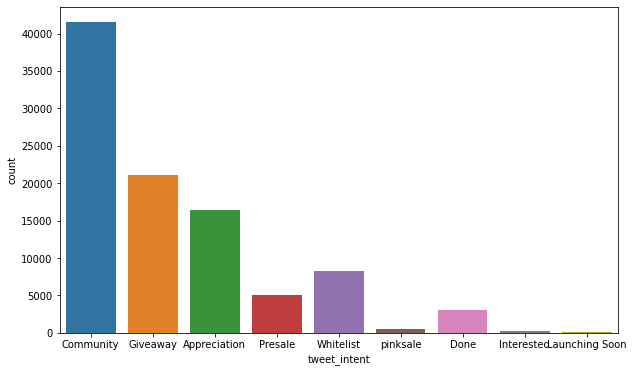

In [7]:
# visualizing intent class counts
plt.figure(figsize=(10,6))
sb.countplot(x=df.tweet_intent)

In [8]:
# from the tweets, URLs, twitter handles, punctuations, numbers and '#' from hashtags will be removed
# and the cleaned text will only include cleaned text

def clean_text(text):
    toks = text.split()
    toks = [t for t in toks if not val.url(t) and '@' not in t]
    toks = ' '.join(toks)
    for p in string.punctuation:
        if p not in ('#','@'):
            toks = toks.replace(p,' ')
    toks = toks.lower().split()
    toks = [t for t in toks if '@' not in t]
    toks = en_model(" ".join(toks))
    toks = [t for t in toks if str(t)!="'s"]
    toks = [t for t in toks if not t.is_stop and not t.is_digit]
    toks = [str(t) for t in toks if len(str(t))>1 and t.is_alpha]
    return ' '.join(toks)

In [9]:
# checking original vs cleaned text
for _ in range(6):
    i = np.random.randint(0,len(df))
    print('Original : '+df.tweet_text[i]+'\n\nCleaned : '+clean_text(df.tweet_text[i]))
    print('\nIntent :',df.tweet_intent[i])
    print('-------------------------------------------------------')

Original : @SundayMondayBot Feature it on @Globalnft07
We have a great community of nft artists and nft collectors

Cleaned : feature great community nft artists nft collectors

Intent : Community
-------------------------------------------------------
Original : @smarcelo PROJECT 21 - THE BEST GAMEFI PROJECT ON BSC
âœ…Multistage deflation tool - PRO21
âœ…Multi-feature NFT
âœ…App on AppStore and Google Play
âœ…Presale in August.

$P21 IS GOING TO THE MOON!
Whitelist: https://t.co/7PsDxNxB2o
TG: https://t.co/EgO2W3RB2X
#Project21 #P21 #Gamefi

Cleaned : project best gamefi project bsc âœ multistage deflation tool âœ multi feature nft âœ app appstore google play âœ presale august going moon whitelist tg gamefi

Intent : Whitelist
-------------------------------------------------------
Original : @autumngives @DjPrestigeUk @princesspromos_ @Yae_NFT Bismillh
Done all rulles

Cleaned : bismillh rulles

Intent : Done
-------------------------------------------------------
Original : Seedify 

In [10]:
# create seperate column for cleaned text
df['clean_text'] = df.tweet_text.apply(lambda x: clean_text(x))

In [11]:
df.clean_text = df.clean_text.apply(lambda x: str(x).replace('amp','')) #some remaining cleaning

In [12]:
#get word count of cleaned text
df['word_count'] = df.clean_text.apply(lambda x: len(str(x).split())) 

In [13]:
df=df.drop('id',axis=1)

<AxesSubplot:xlabel='tweet_intent', ylabel='word_count'>

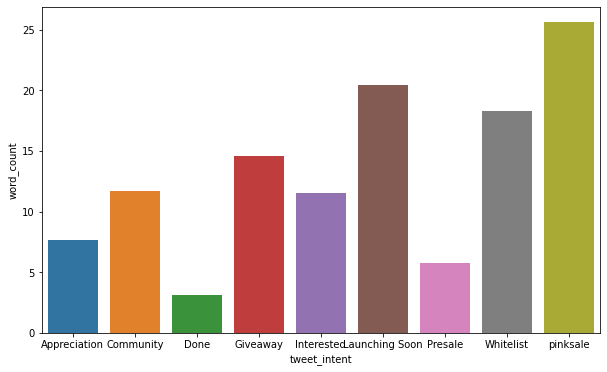

In [14]:
# visualizing mean word count of every intent
mean_word_count = df.groupby('tweet_intent').mean()
plt.figure(figsize=(10,6))
sb.barplot(data = mean_word_count,y='word_count',x=mean_word_count.index)

In [15]:
# splitting data

X = df.clean_text #input text
categs = list(df.tweet_intent.unique())
mapping = dict([(x,i) for i,x in enumerate(categs)])
y = df.tweet_intent.map(mapping) #mapped intents (0 to 8)

# splitting data for training, validation and testing 
xtrain,xtest,ytrain,ytest = train_test_split(X,y,train_size=0.8)
xtrain,xval,ytrain,yval = train_test_split(xtrain,ytrain,train_size=0.8)

maxlen = df.word_count.max() #max input length

# tokenizing and padding the data
tk = Tokenizer()
tk.fit_on_texts(X)

seq = tk.texts_to_sequences(xtrain)
xtrain = pad_sequences(seq,maxlen=maxlen,padding='post')

seq = tk.texts_to_sequences(xval)
xval = pad_sequences(seq,maxlen=maxlen,padding='post')

seq = tk.texts_to_sequences(xtest)
xtest = pad_sequences(seq,maxlen=maxlen,padding='post')

x_voc = len(tk.word_counts)+1

xtrain.shape,xtest.shape,xval.shape

((61672, 45), (19273, 45), (15419, 45))

In [16]:
# loading pretrained glove embeddings
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r',encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model
 
glove_embeddings = load_glove_model("D:/glove.6B.300d.txt")

Loading Glove Model
400000 words loaded!


In [17]:
# creating embedding matrix
emb = np.zeros((x_voc,300))
for w,idx in tk.word_index.items():
    try: emb[idx] = glove_embeddings[w]
    except: pass

In [18]:
# providing class weights as the data seems very imbalanced
weight = class_weight.compute_class_weight('balanced',y=ytrain,classes=np.unique(ytrain))
weight = dict([(i,x) for i,x in enumerate(weight)])

In [19]:
# custom linear attention layer
class LinearAttention(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
    
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)
        super().build(input_shape)
 
    
    def call(self,x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        e = K.squeeze(e, axis=-1)   
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [20]:
# LSTM based model with attention
inputs = Input((maxlen,))
x = Embedding(x_voc,emb.shape[1],weights=[emb],trainable=True)(inputs)
x = LSTM(300,return_sequences=True)(x)
x = LinearAttention()(x)
x = Dense(100,activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(len(mapping),activation='softmax')(x)

model = Model(inputs=inputs,outputs=x,name='lstm_model')
model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(learning_rate=7e-4),metrics='accuracy')
model.summary()


Model: "lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 45)]              0         
                                                                 
 embedding (Embedding)       (None, 45, 300)           8633400   
                                                                 
 lstm (LSTM)                 (None, 45, 300)           721200    
                                                                 
 linear_attention (LinearAtt  (None, 300)              345       
 ention)                                                         
                                                                 
 dense (Dense)               (None, 100)               30100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                        

In [21]:
# training the model and saving the best weights
checkpoint = ModelCheckpoint('lstm_best_weights.h5',save_best_only=True)
model.fit(xtrain,ytrain,validation_data=(xval,yval),epochs=4,batch_size=64,callbacks=[checkpoint],class_weight=weight)

Epoch 1/4
964/964 [==============================] - 20s 18ms/step - loss: 0.5852 - accuracy: 0.8231 - val_loss: 0.2534 - val_accuracy: 0.9350
Epoch 2/4
964/964 [==============================] - 18s 19ms/step - loss: 0.2015 - accuracy: 0.9429 - val_loss: 0.2076 - val_accuracy: 0.9501
Epoch 3/4
964/964 [==============================] - 21s 22ms/step - loss: 0.1535 - accuracy: 0.9556 - val_loss: 0.1822 - val_accuracy: 0.9525
Epoch 4/4
964/964 [==============================] - 22s 22ms/step - loss: 0.1124 - accuracy: 0.9632 - val_loss: 0.1803 - val_accuracy: 0.9532


In [22]:
# load model best weights and evaluate with testing data
model.load_weights('lstm_best_weights.h5')
model.evaluate(xtest,ytest)

603/603 [==============================] - 3s 5ms/step - loss: 0.1807 - accuracy: 0.9518


[0.18066149950027466, 0.9517978429794312]

482/482 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      6679
           1       1.00      0.94      0.97      3421
           2       0.96      0.96      0.96      2611
           3       0.95      0.98      0.96       776
           4       0.84      0.88      0.86      1315
           5       0.93      0.99      0.95        75
           6       0.69      0.91      0.79       479
           7       0.84      0.96      0.90        50
           8       0.65      1.00      0.79        13

    accuracy                           0.95     15419
   macro avg       0.87      0.95      0.91     15419
weighted avg       0.96      0.95      0.95     15419



<AxesSubplot:>

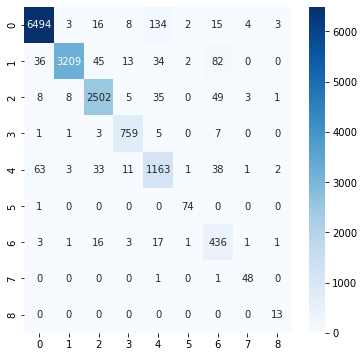

In [23]:
# classification report and confusion matrix of validation data
pred = model.predict(xval)
pred = [np.argmax(x) for x in pred]
print(classification_report(yval,pred))
plt.figure(figsize=(6,6))
sb.heatmap(confusion_matrix(yval,pred),annot=True,fmt='d',cmap='Blues')

603/603 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      8273
           1       1.00      0.94      0.97      4183
           2       0.94      0.96      0.95      3323
           3       0.95      0.97      0.96      1005
           4       0.85      0.87      0.86      1699
           5       0.94      0.99      0.96        96
           6       0.70      0.92      0.79       609
           7       0.77      1.00      0.87        55
           8       0.81      0.97      0.88        30

    accuracy                           0.95     19273
   macro avg       0.88      0.95      0.91     19273
weighted avg       0.96      0.95      0.95     19273



<AxesSubplot:>

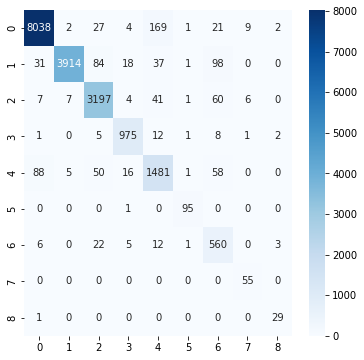

In [24]:
# classification report and confusion matrix of testing data
pred = model.predict(xtest)
pred = [np.argmax(x) for x in pred]
print(classification_report(ytest,pred))
plt.figure(figsize=(6,6))
sb.heatmap(confusion_matrix(ytest,pred),annot=True,fmt='d',cmap='Blues')

In [25]:
# now trying a transformer based model
# this model encodes the whole sequence at onec, unlike the former
# it uses multi-head attention

emb = np.zeros((x_voc,300))
for w,idx in tk.word_index.items():
    try: emb[idx] = glove_embeddings[w]
    except: pass

In [26]:
# custom transformer layer
class TransformerLayer(tf.keras.layers.Layer):
    def __init__(self, emb_dim, num_heads, dense_units, dropout_rate=0.1,**kwargs):
        self.dim = emb_dim
        self.heads = num_heads
        self.units = dense_units
        self.rate = dropout_rate
        super().__init__(**kwargs)
    
    def build(self,input_shape):
        self.ln1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.ln2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.drop1 = Dropout(self.rate)
        self.drop2 = Dropout(self.rate)
        self.ff = Dense(self.units,activation='relu')
        self.ff_out = Dense(self.dim)
        self.attn = tf.keras.layers.MultiHeadAttention(num_heads=self.heads, key_dim=self.dim)
        super().build(input_shape)
        
    def call(self,inputs):
        att_out = self.attn(inputs,inputs)
        att_out = self.drop1(att_out)
        ln_out = self.ln1(att_out+inputs)
        ff_out = self.ff(ln_out)
        ff_out = self.ff_out(ff_out)
        ff_out = self.drop2(ff_out)
        return self.ln2(ln_out+ff_out)
    
    def get_config(self):
        config = super().get_config()
        config.update({
        'emb_dim' : self.dim,
        'num_heads' : self.heads, 
        'dense_units' : self.units,
        'dropout_rate' : self.rate})
        return config
        

In [27]:
# custom word embedding layer
class WordnPosEmb(tf.keras.layers.Layer):
    def __init__(self,maxlen,vocab_size,emb_dim,pretrained_weights=None,**kwargs):
        self.max = maxlen
        self.voc = vocab_size
        self.dim = emb_dim
        self.pretrained = pretrained_weights
        super().__init__(**kwargs)
        
    def build(self,input_shape):
        self.word_emb = Embedding(input_dim=self.voc,output_dim=self.dim,weights=[self.pretrained],trainable=True)
        self.pos_emb = Embedding(input_dim=self.max,output_dim=self.dim)
        super().build(input_shape)
    
    def call(self,x):
        pos = tf.shape(x)[-1]
        pos = self.pos_emb(pos)
        x = self.word_emb(x)
        return x+pos
    
    def get_config(self):
        config = super().get_config()
        config.update({
        'maxlen':self.max,
        'vocab_size':self.voc,
        'emb_dim':self.dim,
        'pretrained_weights':self.pretrained})
        return config
    
        

In [28]:
# building the transformer based model
inp = Input(shape=(maxlen,))
l = WordnPosEmb(maxlen,x_voc,300,pretrained_weights=emb)(inp)
l = TransformerLayer(emb_dim=300,num_heads=2,dense_units=100)(l)
l = tf.keras.layers.GlobalAveragePooling1D()(l)
out = Dense(len(mapping),activation='softmax')(l)

model = Model(inp,out,name='transformer_model')
model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(learning_rate=7e-4),metrics=['accuracy'])
model.summary()

Model: "transformer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 45)]              0         
                                                                 
 wordn_pos_emb (WordnPosEmb)  (None, 45, 300)          8646900   
                                                                 
 transformer_layer (Transfor  (None, 45, 300)          783700    
 merLayer)                                                       
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_2 (Dense)             (None, 9)                 2709      
                                                                 
Total params: 9,433,309
Trainable params: 9,433,3

In [29]:
# training the model and saving the best weights
checkpoint = ModelCheckpoint('transformer_best_weights.h5',save_best_only=True)
model.fit(xtrain,ytrain,validation_data=(xval,yval),epochs=4,batch_size=64,callbacks=[checkpoint],class_weight=weight)

Epoch 1/4
964/964 [==============================] - 31s 31ms/step - loss: 0.4366 - accuracy: 0.8725 - val_loss: 0.2029 - val_accuracy: 0.9489
Epoch 2/4
964/964 [==============================] - 48s 50ms/step - loss: 0.1728 - accuracy: 0.9477 - val_loss: 0.1786 - val_accuracy: 0.9556
Epoch 3/4
964/964 [==============================] - 71s 73ms/step - loss: 0.1195 - accuracy: 0.9610 - val_loss: 0.2183 - val_accuracy: 0.9506
Epoch 4/4
964/964 [==============================] - 86s 89ms/step - loss: 0.0962 - accuracy: 0.9668 - val_loss: 0.1888 - val_accuracy: 0.9554


In [30]:
# loading best weights and evaluating with testing data
model.load_weights('transformer_best_weights.h5')
model.evaluate(xtest,ytest)

603/603 [==============================] - 10s 16ms/step - loss: 0.1834 - accuracy: 0.9533


[0.18337836861610413, 0.9532506465911865]

603/603 [==============================] - 4s 7ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      8273
           1       1.00      0.93      0.96      4183
           2       0.94      0.96      0.95      3323
           3       0.96      0.97      0.97      1005
           4       0.92      0.84      0.88      1699
           5       0.93      0.99      0.96        96
           6       0.63      0.94      0.75       609
           7       0.83      0.98      0.90        55
           8       0.66      0.97      0.78        30

    accuracy                           0.95     19273
   macro avg       0.87      0.95      0.90     19273
weighted avg       0.96      0.95      0.95     19273



<AxesSubplot:>

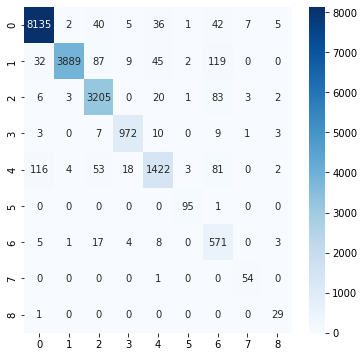

In [31]:
# classification report and confusion matrix of testing data
pred = model.predict(xtest)
pred = [np.argmax(x) for x in pred]
print(classification_report(ytest,pred))
plt.figure(figsize=(6,6))
sb.heatmap(confusion_matrix(ytest,pred),annot=True,fmt='d',cmap='Blues')

482/482 [==============================] - 4s 9ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6679
           1       0.99      0.93      0.96      3421
           2       0.95      0.96      0.95      2611
           3       0.97      0.98      0.97       776
           4       0.92      0.86      0.89      1315
           5       0.87      0.99      0.93        75
           6       0.63      0.93      0.75       479
           7       0.91      0.98      0.94        50
           8       0.65      1.00      0.79        13

    accuracy                           0.96     15419
   macro avg       0.88      0.96      0.91     15419
weighted avg       0.96      0.96      0.96     15419



<AxesSubplot:>

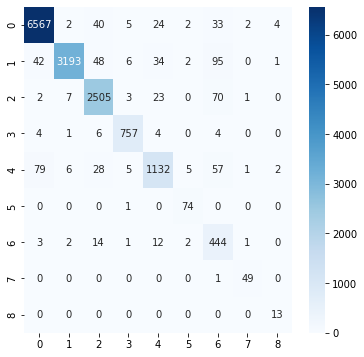

In [32]:
# classification report and confusion matrix of validation data
pred = model.predict(xval)
pred = [np.argmax(x) for x in pred]
print(classification_report(yval,pred))
plt.figure(figsize=(6,6))
sb.heatmap(confusion_matrix(yval,pred),annot=True,fmt='d',cmap='Blues')

In [56]:
# after training the model few times, I observe that most of the time,
# the transformer model performs better than the LSTM one

# now to fill the missing intents

input_text = test.tweet_text.apply(lambda x: clean_text(x))

In [40]:
# prediction function
def get_intents(x,tokenizer,model):
    x = tokenizer.texts_to_sequences(x)
    x = pad_sequences(x,maxlen=maxlen,padding='post')
    pred = model.predict(x)
    return [np.argmax(x) for x in pred]    

In [41]:
pred = get_intents(input_text,tk,model)

reverse_mapping = dict([(mapping[x],x) for x in mapping.keys()])

tweet_data = pd.read_csv('Tweet_NFT.xlsx - Sheet1.csv')

# filling missing intents
for i in test.index:
    tweet_id = test.id.loc[i]
    ind = tweet_data[tweet_data.id==tweet_id].index[0]
    tweet_data.tweet_intent.loc[ind] = reverse_mapping[pred[i]]

# save the data to .csv
tweet_data.to_csv('filled_missing.csv',index=False)

972/972 [==============================] - 4s 4ms/step
